In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE

device(type='cuda')

In [2]:
# Set hyper parameters
EPOCHS = 100
BATCH_SIZE = 256

## Load dataset



In [3]:
train_loader = torch.utils.data.DataLoader(
datasets.CIFAR100('./.data',
  train=True,
  download=True,
  transform=transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5),
  (0.5, 0.5, 0.5))])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
datasets.CIFAR100('./.data',
  train=False,
  transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5),
  (0.5, 0.5, 0.5))])),
  batch_size=BATCH_SIZE, shuffle=True)


Files already downloaded and verified


# 1. DNN

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(3*32*32, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 100) # CIFAR100 데이터는 100개의 클래스로 분류되기 때문에 100으로 수정
  def forward(self, x):
    x = x.view(-1, 3*32*32)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [5]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [6]:
def train(model, train_loader, optimizer):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(DEVICE), target.to(DEVICE) # 학습 데이터를 DEVICE의 메모리로 보냄
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()


In [7]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = model(data)
      # 모든 오차 더하기
      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      # 가장 큰 값을 가진 클래스가 모델의 예측입니다.
      # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더합니다.
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy


In [8]:
test_loss_history = []
test_accuracy_history = []
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer)
  test_loss, test_accuracy = evaluate(model, test_loader)
  test_loss_history.append(test_loss)
  test_accuracy_history.append(test_accuracy)
  print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
    epoch, test_loss, test_accuracy))

[1] Test Loss: 4.5888, Accuracy: 1.87%
[2] Test Loss: 4.5634, Accuracy: 3.32%
[3] Test Loss: 4.5217, Accuracy: 3.92%
[4] Test Loss: 4.4537, Accuracy: 4.40%
[5] Test Loss: 4.3613, Accuracy: 4.90%
[6] Test Loss: 4.2757, Accuracy: 5.49%
[7] Test Loss: 4.2116, Accuracy: 6.50%
[8] Test Loss: 4.1665, Accuracy: 6.75%
[9] Test Loss: 4.1306, Accuracy: 7.45%
[10] Test Loss: 4.1017, Accuracy: 7.47%
[11] Test Loss: 4.0773, Accuracy: 8.14%
[12] Test Loss: 4.0535, Accuracy: 8.21%
[13] Test Loss: 4.0343, Accuracy: 8.57%
[14] Test Loss: 4.0147, Accuracy: 9.01%
[15] Test Loss: 3.9961, Accuracy: 9.20%
[16] Test Loss: 3.9775, Accuracy: 9.24%
[17] Test Loss: 3.9584, Accuracy: 9.79%
[18] Test Loss: 3.9409, Accuracy: 10.04%
[19] Test Loss: 3.9264, Accuracy: 10.09%
[20] Test Loss: 3.9148, Accuracy: 10.12%
[21] Test Loss: 3.8947, Accuracy: 10.66%
[22] Test Loss: 3.8848, Accuracy: 10.54%
[23] Test Loss: 3.8715, Accuracy: 11.11%
[24] Test Loss: 3.8568, Accuracy: 11.32%
[25] Test Loss: 3.8485, Accuracy: 11.43%
[

In [9]:
torch.save(model.state_dict(), 'DNN.pt')

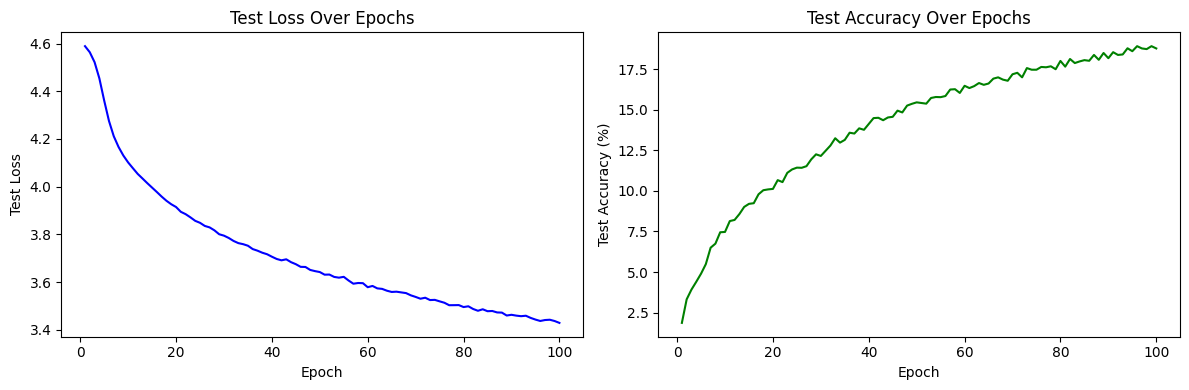

In [10]:
plt.figure(figsize=(12, 4))

# 그래프 1: 테스트 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), test_loss_history, linestyle='-', color='b')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')

# 그래프 2: 테스트 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), test_accuracy_history, linestyle='-', color='g')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')

plt.tight_layout()
plt.show()

In [11]:
print("최소 loss값: ", min(test_loss_history))
print("최대 acc값: ", max(test_accuracy_history))

최소 loss값:  3.429167110443115
최대 acc값:  18.91


# 2. CNN

In [12]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)  #CIFAR100은 채널이 3개인 데이터셋이라 input채널 수를 1에서 3으로 변경
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(20*5*5, 50)
    self.fc2 = nn.Linear(50, 100)
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    # print(x.shape) #x.shape()
    x = x.view(-1, 20*5*5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return x

In [13]:
model = CNN().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [14]:
def train(model, train_loader, optimizer):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()



In [15]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = model(data)
      # 배치 오차를 합산
      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      # 가장 높은 값을 가진 인덱스가 바로 예측값
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [16]:
test_loss_history = []
test_accuracy_history = []
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer)
  test_loss, test_accuracy = evaluate(model, test_loader)
  test_loss_history.append(test_loss)
  test_accuracy_history.append(test_accuracy)
  print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

[1] Test Loss: 4.6063, Accuracy: 1.09%
[2] Test Loss: 4.6048, Accuracy: 1.23%
[3] Test Loss: 4.6028, Accuracy: 1.51%
[4] Test Loss: 4.5994, Accuracy: 1.60%
[5] Test Loss: 4.5921, Accuracy: 1.51%
[6] Test Loss: 4.5783, Accuracy: 1.53%
[7] Test Loss: 4.5580, Accuracy: 1.44%
[8] Test Loss: 4.5389, Accuracy: 1.72%
[9] Test Loss: 4.5186, Accuracy: 2.03%
[10] Test Loss: 4.5048, Accuracy: 2.28%
[11] Test Loss: 4.4837, Accuracy: 2.47%
[12] Test Loss: 4.4676, Accuracy: 2.48%
[13] Test Loss: 4.4478, Accuracy: 2.47%
[14] Test Loss: 4.4315, Accuracy: 2.89%
[15] Test Loss: 4.4176, Accuracy: 2.57%
[16] Test Loss: 4.4037, Accuracy: 2.81%
[17] Test Loss: 4.3916, Accuracy: 3.07%
[18] Test Loss: 4.3841, Accuracy: 3.03%
[19] Test Loss: 4.3735, Accuracy: 2.99%
[20] Test Loss: 4.3646, Accuracy: 3.08%
[21] Test Loss: 4.3542, Accuracy: 3.31%
[22] Test Loss: 4.3417, Accuracy: 3.36%
[23] Test Loss: 4.3355, Accuracy: 3.58%
[24] Test Loss: 4.3236, Accuracy: 3.91%
[25] Test Loss: 4.3166, Accuracy: 3.96%
[26] Test

In [17]:
torch.save(model.state_dict(), 'CNN.pt')

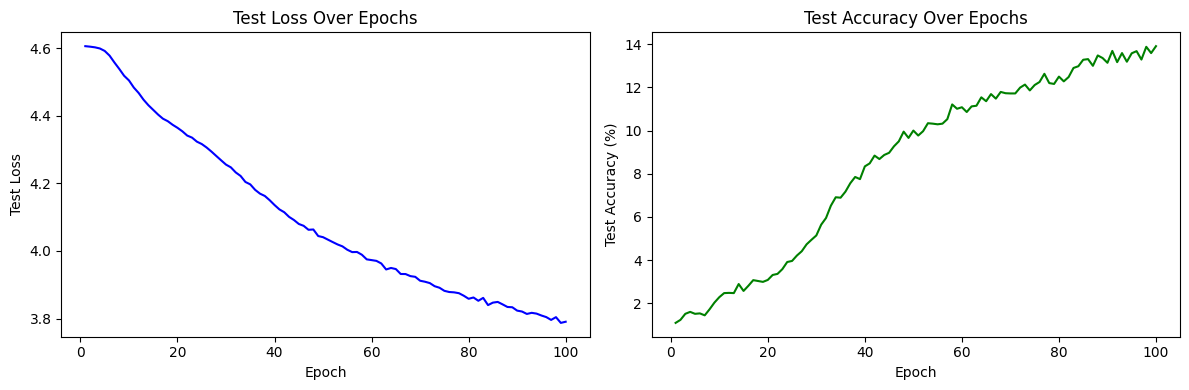

In [18]:
plt.figure(figsize=(12, 4))

# 그래프 1: 테스트 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), test_loss_history, linestyle='-', color='b')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')

# 그래프 2: 테스트 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), test_accuracy_history, linestyle='-', color='g')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')

plt.tight_layout()
plt.show()

In [19]:
print("최소 loss값: ", min(test_loss_history))
print("최대 acc값: ", max(test_accuracy_history))

최소 loss값:  3.7870512928009035
최대 acc값:  13.91


# 3. ResNet

In [20]:
class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
      stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
      stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != planes:
      self.shortcut = nn.Sequential(
      nn.Conv2d(in_planes, planes,
        kernel_size=1, stride=stride, bias=False),
      nn.BatchNorm2d(planes)
      )
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


In [21]:
class ResNet(nn.Module):
  def __init__(self, num_classes=100):
    super(ResNet, self).__init__()
    self.in_planes = 16
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer1 = self._make_layer(16, 2, stride=1)
    self.layer2 = self._make_layer(32, 2, stride=2)
    self.layer3 = self._make_layer(64, 2, stride=2)
    self.linear = nn.Linear(64, num_classes)
  def _make_layer(self, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_planes, planes, stride))
      self.in_planes = planes
    return nn.Sequential(*layers)
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = F.avg_pool2d(out, 8) 
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [22]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)  #Adam으로 바꿔보자
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [23]:
def train(model, train_loader, optimizer):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(DEVICE), target.to(DEVICE) # 학습 데이터를 DEVICE의 메모리로 보냄
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()


In [24]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = model(data)
      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy


In [25]:
test_loss_history = []
test_accuracy_history = []
for epoch in range(1, EPOCHS + 1):
  scheduler.step()
  train(model, train_loader, optimizer)
  test_loss, test_accuracy = evaluate(model, test_loader)
  test_loss_history.append(test_loss)
  test_accuracy_history.append(test_accuracy)
  print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

C:\Users\USER\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[1] Test Loss: 3.7613, Accuracy: 11.41%
[2] Test Loss: 3.4066, Accuracy: 17.69%
[3] Test Loss: 3.1946, Accuracy: 22.74%
[4] Test Loss: 2.8885, Accuracy: 27.35%
[5] Test Loss: 2.7956, Accuracy: 30.12%
[6] Test Loss: 2.3479, Accuracy: 37.41%
[7] Test Loss: 2.3955, Accuracy: 37.41%
[8] Test Loss: 2.6404, Accuracy: 35.07%
[9] Test Loss: 2.3859, Accuracy: 39.62%
[10] Test Loss: 2.6468, Accuracy: 37.31%
[11] Test Loss: 2.4017, Accuracy: 39.71%
[12] Test Loss: 2.6180, Accuracy: 37.31%
[13] Test Loss: 2.2507, Accuracy: 41.14%
[14] Test Loss: 2.2847, Accuracy: 40.40%
[15] Test Loss: 2.2014, Accuracy: 42.51%
[16] Test Loss: 2.1894, Accuracy: 42.65%
[17] Test Loss: 2.3691, Accuracy: 41.58%
[18] Test Loss: 2.3423, Accuracy: 41.33%
[19] Test Loss: 1.9129, Accuracy: 48.86%
[20] Test Loss: 2.2007, Accuracy: 43.91%
[21] Test Loss: 2.0470, Accuracy: 45.80%
[22] Test Loss: 1.9127, Accuracy: 48.16%
[23] Test Loss: 1.9804, Accuracy: 47.86%
[24] Test Loss: 2.2259, Accuracy: 44.04%
[25] Test Loss: 2.0747, A

In [26]:
torch.save(model.state_dict(), 'ResNet.pt')

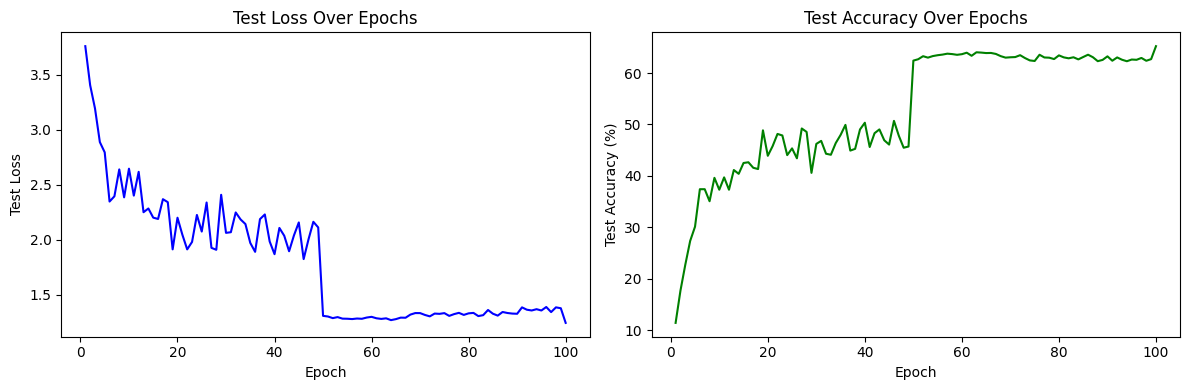

In [27]:
plt.figure(figsize=(12, 4))

# 그래프 1: 테스트 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), test_loss_history, linestyle='-', color='b')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')

# 그래프 2: 테스트 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), test_accuracy_history, linestyle='-', color='g')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')

plt.tight_layout()
plt.show()

In [28]:
print("최소 loss값: ", min(test_loss_history))
print("최대 acc값: ", max(test_accuracy_history))


최소 loss값:  1.2439772972106933
최대 acc값:  65.23


# 4.Customize

In [29]:
EPOCHS = 200
BATCH_SIZE = 16

In [30]:
train_loader = torch.utils.data.DataLoader(
datasets.CIFAR100('./.data',
  train=True,
  download=True,
  transform=transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5),
  (0.5, 0.5, 0.5))])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
datasets.CIFAR100('./.data',
  train=False,
  transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5),
  (0.5, 0.5, 0.5))])),
  batch_size=BATCH_SIZE, shuffle=True)


Files already downloaded and verified


In [31]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
          stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
          stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, planes,
            kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
  def __init__(self, num_classes=100):
    super(ResNet, self).__init__()
    self.in_planes = 32 # conv1에서 나올 채널의 차원
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(32)
    self.layer1 = self._make_layer(32, 2, stride=1)
    self.layer2 = self._make_layer(64, 2, stride=2)
    self.layer3 = self._make_layer(128, 2, stride=2)
    self.layer4 = self._make_layer(256, 2, stride=1)
    self.layer5 = self._make_layer(512, 2, stride=1)
    self.linear = nn.Linear(512, 256)
    self.linear1 = nn.Linear(256, num_classes)
  def _make_layer(self, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_planes, planes, stride))
      self.in_planes = planes
    return nn.Sequential(*layers)
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x))) 
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = F.max_pool2d(out, 8) 
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    out = self.linear1(out)
    return out


In [33]:
model = ResNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.0005)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  #epoch 50 이후에 학습률 0.1의 곱으로 줄어든다

In [34]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) # 학습 데이터를 DEVICE의 메모리로 보냄
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [35]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            # print(output)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [12]:
test_loss_history = []
test_accuracy_history = []

for epoch in range(1, EPOCHS + 1):
    scheduler.step()        

    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

C:\Users\USER\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[1] Test Loss: 3.3580, Accuracy: 19.20%
[2] Test Loss: 2.7432, Accuracy: 30.70%
[3] Test Loss: 2.3320, Accuracy: 38.42%
[4] Test Loss: 2.1296, Accuracy: 43.46%
[5] Test Loss: 1.9906, Accuracy: 46.29%
[6] Test Loss: 1.8132, Accuracy: 50.67%
[7] Test Loss: 1.6617, Accuracy: 54.05%
[8] Test Loss: 1.6727, Accuracy: 54.32%
[9] Test Loss: 1.5515, Accuracy: 56.77%
[10] Test Loss: 1.5064, Accuracy: 58.18%
[11] Test Loss: 1.4155, Accuracy: 60.07%
[12] Test Loss: 1.4130, Accuracy: 60.86%
[13] Test Loss: 1.4525, Accuracy: 59.95%
[14] Test Loss: 1.3611, Accuracy: 62.57%
[15] Test Loss: 1.3740, Accuracy: 61.85%
[16] Test Loss: 1.3195, Accuracy: 63.88%
[17] Test Loss: 1.3430, Accuracy: 63.53%
[18] Test Loss: 1.3101, Accuracy: 64.12%
[19] Test Loss: 1.3387, Accuracy: 63.40%
[20] Test Loss: 1.2982, Accuracy: 65.03%
[21] Test Loss: 1.3120, Accuracy: 64.42%
[22] Test Loss: 1.2396, Accuracy: 66.86%
[23] Test Loss: 1.2478, Accuracy: 66.53%
[24] Test Loss: 1.3144, Accuracy: 65.83%
[25] Test Loss: 1.3126, A

[199] Test Loss: 1.3018, Accuracy: 73.52%
[200] Test Loss: 1.2982, Accuracy: 73.55%


In [13]:
torch.save(model.state_dict(), 'Customized_ResNet.pt')

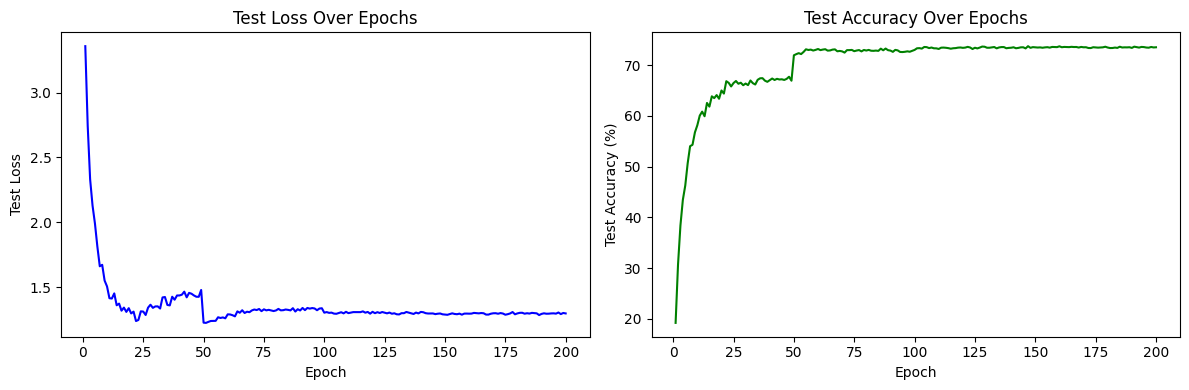

In [14]:
plt.figure(figsize=(12, 4))

# 그래프 1: 테스트 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), test_loss_history, linestyle='-', color='b')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')

# 그래프 2: 테스트 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), test_accuracy_history, linestyle='-', color='g')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')

plt.tight_layout()
plt.show()

In [15]:
print("최소 loss값: ", min(test_loss_history))
print("최대 acc값: ", max(test_accuracy_history))


최소 loss값:  1.2253319536209106
최대 acc값:  73.77
